# <center>ECHO-VMAT Tutorial </center>

Volumetric Modulated Arc Therapy (VMAT) has increasingly become the preferred treatment method for many disease sites, primarily due to its fast plan delivery and dose distribution comparable to that of IMRT. However, the optimization of numerous apertures and their corresponding monitor units results in challenging large-scale non-convex optimization problems. To address these challenges, researchers often resort to computationally efficient heuristic methods. Having a globally optimal solution as a benchmark can significantly aid in the development and validation of new VMAT algorithms (see [vmat_global_optimal.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/vmat_global_optimal.ipynb) notebook).

In this notebook, we introduce an example of doing automated planning using hiearchial optimization with sequential convex programming based algorithm based on our recent publications ([Dursun et al 2021](https://iopscience.iop.org/article/10.1088/1361-6560/abee58/meta) and [Dursun et al 2023](https://iopscience.iop.org/article/10.1088/1361-6560/ace09e/meta)). This algorithm, called Sequential Convex Programming (SCP), solves a sequence of convex optimization problems that converge to the original non-convex VMAT problem. This technique should not be confused with hierarchical optimization (also known as prioritized optimization), which we utilized in our publication ([Dursun et al 2023](https://iopscience.iop.org/article/10.1088/1361-6560/ace09e/meta)) to automate the planning process. We suggest you to go through the main algorithm [vmat_scp_tutorial.ipynb](https://githubcom/PortPy-Project/PortPy/blob/master/examples/vmat_scp_tutorial.ipynb) notebook on main PortPy repo to understand about the core scp-based algorithm. This notebook is an extension of SCP based VMAT algorith for performing automated planning using hiearchial technqiue.


### This example demonstrates the following main functionalities of portpy.photon.vmat module:


1. Accessing the portpy beam data as a set of dicrete beams for vmat control points
    (DataExplorer class). Creating Arcs based upon the beam ids (Arcs class)

2. Creating a Plan and intalize ECHO VMAT Optimization class
    (Plan class, VmatScpOptimization class)

3. Run Step 0, 1 and 2 of ECHO-VMAT for automated planning

5. Visualizing and Evaluating the plan (e.g., max/mean/DVH points, established clinical metrics)
    (Evaluation class, Visualization Class)

6. Pushing the plan to TPS for further evaluation
    (Utils)


### 1) Accessing the portpy data (DataExplorer class)
 To start using this resource, users are required to download the latest version of the dataset, which can be found [here](https://drive.google.com/drive/folders/1nA1oHEhlmh2Hk8an9e0Oi0ye6LRPREit). Then, the dataset can be accessed as demonstrated below.



In [3]:
import sys
sys.path.append('..')
sys.path.append('../../PortPy')

In [4]:
# If you're running PortPy for the first time, you need to install the requirements 
#!pip install -r ..\requirements.txt

In [5]:
import portpy.photon as pp
import numpy as np
import os
from echo_vmat.echo_vmat_optimization import EchoVmatOptimization
from echo_vmat.echo_vmat_optimization_col_gen import EchoVmatOptimizationColGen
import matplotlib.pyplot as plt
from echo_vmat.arcs import Arcs
import time
from copy import deepcopy
from echo_vmat.utils.get_sparse_only import get_sparse_only

In [6]:
# specify the patient data location.
data_dir = r'../../PortPy/data'
data = pp.DataExplorer(data_dir=data_dir)
data.patient_id = 'Lung_Patient_4'

In [7]:
# display the data of the patient in console or browser.
beams_df, structs_df = data.display_patient_metadata(return_beams_df=True, return_structs_df=True)
beams_df.head()
# display in browser rather than console. Set in_browser to True
# data.display_patient_metadata(in_browser=True)

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': -59.32016, 'y_mm': 4.785892, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': -59.32016, 'y_mm': 4.785892, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': -59.32016, 'y_mm': 4.785892, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': -59.32016, 'y_mm': 4.785892, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': -59.32016, 'y_mm': 4.785892, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


In [8]:
# Load clinical criteria and optimization parameters from the config files. They are located in ./echo_vmat/config_files. Users can modify the clinical criteria and optimization parameters based upon their needs
config_path = os.path.join(os.getcwd(), '..', 'echo_vmat', 'config_files')
protocol_name = 'Lung_2Gy_30Fx'
filename = os.path.join(config_path, protocol_name + '_opt_params.json')
vmat_opt_params = data.load_json(file_name=filename)

# check if sparse/original matrix to be loaded
if "flag_full_matrix" in vmat_opt_params['opt_parameters']:
    flag_full_matrix = vmat_opt_params['opt_parameters']['flag_full_matrix']
else:
    flag_full_matrix = False

ct = pp.CT(data)
structs = pp.Structures(data)

# Users can modify the arcs based upon the start and stop gantry angles.
# Below is an example where 2 arcs area created,
# the start and stop gantry angles 0 to 180 and 180 to 359 are used.
all_beam_ids = np.arange(0, 37)  # 72 beams with gantry angle between 0 to 359 deg and spacing 5 deg
arcs_dict = {'arcs': [{'arc_id': "01", "beam_ids": all_beam_ids[0:int(len(all_beam_ids) / 2)]},
                      {'arc_id': "02", "beam_ids": all_beam_ids[int(len(all_beam_ids) / 2):]}]}

beam_ids = [beam_id for arcs_dict in arcs_dict['arcs'] for beam_id in arcs_dict['beam_ids']]
beams = pp.Beams(data, beam_ids=beam_ids, load_inf_matrix_full=flag_full_matrix)


In [12]:
filename = os.path.join(config_path, protocol_name + '_clinical_criteria.json')
clinical_criteria = pp.ClinicalCriteria(file_name=filename)

if 'Patient Surface' in structs.get_structures():
    ind = structs.structures_dict['name'].index('Patient Surface')
    structs.structures_dict['name'][ind] = 'BODY'

# temporary capitalize the structures
for i in range(len(structs.structures_dict['name'])):
    structs.structures_dict['name'][i] = structs.structures_dict['name'][i].upper()

# # Creating optimization structures (i.e., Rinds, PTV-GTV)
for i in range(len(vmat_opt_params["steps"])):
    structs.create_opt_structures(opt_params=vmat_opt_params["steps"][str(i + 1)],
                                  clinical_criteria=clinical_criteria)

inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams, is_full=flag_full_matrix)  # is_bev=True

arcs = Arcs(arcs_dict=arcs_dict, inf_matrix=inf_matrix) #creating arcs object using the arcs dictionary mentioned in previous cell

Creating optimization structures.. It may take some time due to dilation
Cannot evaluate structure defintion PTV - CTV
Cannot evaluate structure defintion PTV - CTV
Optimization structures created!!
Creating optimization structures.. It may take some time due to dilation
Cannot evaluate structure defintion PTV - CTV
Cannot evaluate structure defintion PTV - CTV
Optimization structures created!!
Creating BEV..
Loading full influence matrix..
Done


In [13]:
# sparsify influence matrix based on user settings. It can be modified by changing vmat_opt_params['opt_parameters']['sparsification']. Default is set to RMR.

# use naive or RMR sparsification
if flag_full_matrix:
    A = deepcopy(inf_matrix.A)
    # A = A * np.float32(2 * clinical_criteria.get_prescription() / clinical_criteria.get_num_of_fractions())
    if "threshold_perc" in vmat_opt_params['opt_parameters']:
        threshold_perc = vmat_opt_params['opt_parameters']['threshold_perc']
    else:
        threshold_perc = 5
    if "sparsification" in vmat_opt_params['opt_parameters']: # Default is RMR sparsification for more accurate results. It can be changed to Naive
        sparsification = vmat_opt_params['opt_parameters']['sparsification']
    else:
        sparsification = 'Naive'
    # threshold_abs = 0.0112*2*clinical_criteria.get_prescription() / clinical_criteria.get_num_of_fractions()
    B = get_sparse_only(A, threshold_perc=threshold_perc, compression=sparsification)
    # # calculate delta
    # delta = A.sum(axis=1) - B.sum(axis=1).A1
    # inf_matrix.opt_voxels_dict['delta'][0] = delta
    inf_matrix.A = B

# scale influence matrix to get correct MU for TPS import
if "inf_matrix_scale_factor" in vmat_opt_params['opt_parameters']:
    inf_matrix_scale_factor = vmat_opt_params['opt_parameters']['inf_matrix_scale_factor']
else:
    inf_matrix_scale_factor = 1
print("inf_matrix_scale_factor: ", inf_matrix_scale_factor)

inf_matrix.A = inf_matrix.A * np.float32(inf_matrix_scale_factor)

Generating sparse matrix using RMR...
inf_matrix_scale_factor:  0.6


### 2) Creating a Plan and intalize ECHO VMAT Optimization class

In [15]:
# Create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria, arcs=arcs)

In [38]:
# generate initial leaf positions using column generation approach else use user defined initial leaf positions. Users can skip this part of the code if they want to start initial leaf positions either random or BEV
if vmat_opt_params['opt_parameters']['initial_leaf_pos'].lower() == 'cg':
    start_col_gen = time.time()
    vmat_opt = EchoVmatOptimizationColGen(my_plan=my_plan,
                                          opt_params=vmat_opt_params,
                                          step_num=1)

    sol_col_gen = vmat_opt.run_col_gen_algo(solver='MOSEK', verbose=False, accept_unknown=True)
    dose_1d = inf_matrix.A @ sol_col_gen['optimal_intensity'] * my_plan.get_num_of_fractions()
    # # plot dvh for the above structures
    fig, ax = plt.subplots(figsize=(12, 8))
    struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'RIND_0', 'RIND_1', 'LUNGS_NOT_GTV', 'RECT_WALL', 'BLAD_WALL',
                    'URETHRA']
    ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_1d,
                                   struct_names=struct_names, ax=ax)
    ax.set_title('Initial Col gen dvh')
    plt.show(block=False)
    plt.close('all')
    # pp.save_optimal_sol(sol=sol_col_gen, sol_name='sol_col_gen', path=r'C:\Temp')

    end_col_gen = time.time()
    print('***************time to generate initial leaf positions = ', end_col_gen - start_col_gen, 'seconds *****************')


### 3) Run Step 0, 1 and 2 of ECHO-VMAT for automated planning

In [18]:
# check if there are dvh constraints in clinical or optimization parameters. If yes, then run step 0
clinical_criteria.get_dvh_table(my_plan=my_plan, opt_params=vmat_opt_params['steps']['2'])
vmat_opt = EchoVmatOptimization(my_plan=my_plan,
                                opt_params=vmat_opt_params,
                                step_num=1)
solutions = []
sol = {}
final_convergence = []

In [36]:
 #Run step 0 for dvh optimization
if not clinical_criteria.dvh_table.empty:
    sol_convergence = vmat_opt.run_sequential_cvx_algo(solver='MOSEK', verbose=False)
    final_convergence.extend(sol_convergence)
    sol = sol_convergence[vmat_opt.best_iteration]
    solutions.append(sol)
    vmat_opt.update_params(step_number=0, sol=sol)

In [34]:
# Run step 1 and 2 for hiearchical optimization
for i in range(2):
    if not clinical_criteria.dvh_table.empty:
        dose = sol['act_dose_v'] * my_plan.get_num_of_fractions()
        clinical_criteria.get_low_dose_vox_ind(my_plan, dose=dose)  # get low dose voxels and update dvh table
    vmat_opt.set_step_num(i + 1)
    # running scp algorithm
    sol_convergence = vmat_opt.run_sequential_cvx_algo(solver='MOSEK', verbose=False)
    final_convergence.extend(sol_convergence)
    sol = final_convergence[vmat_opt.best_iteration]
    solutions.append(sol)
    vmat_opt.update_params(step_number=i + 1, sol=sol)

### 4) Visualizing the plan (Visualization class)

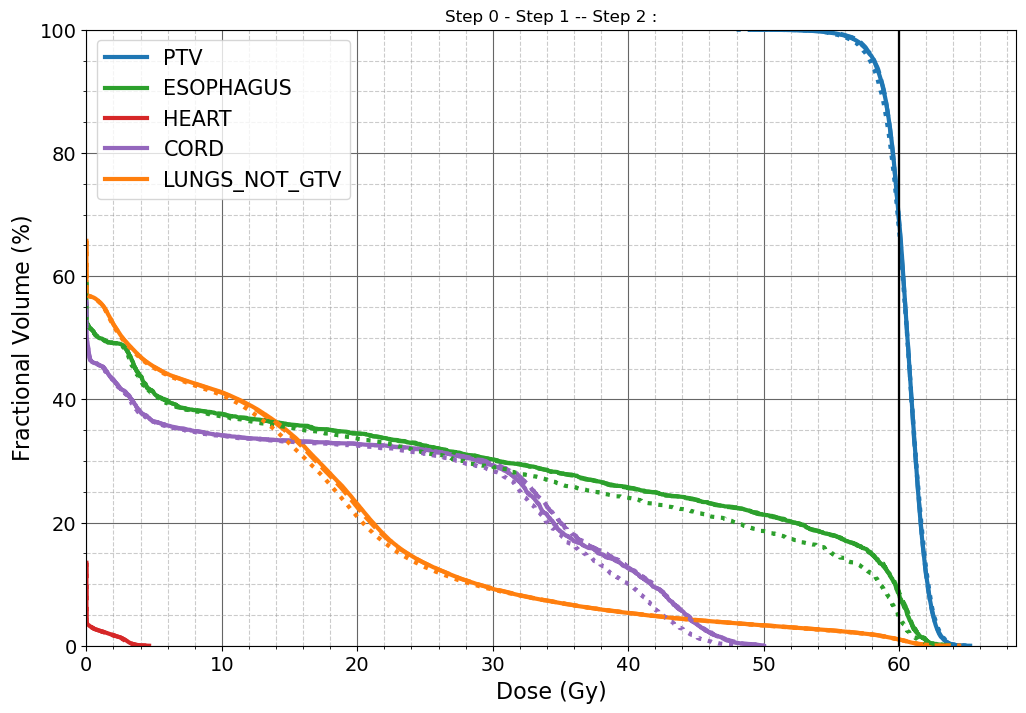

In [22]:

# # plot dvh for the above structures for different steps
fig, ax = plt.subplots(figsize=(12, 8))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'RIND_0', 'RIND_1', 'LUNGS_NOT_GTV', 'RECT_WALL', 'BLAD_WALL',
                'URETHRA']
title = []
style = ['-', '--', ':']
for i in range(len(solutions)):
    ax = pp.Visualization.plot_dvh(my_plan, dose_1d=solutions[i]['act_dose_v'] * my_plan.get_num_of_fractions(),
                                   struct_names=struct_names,
                                   style=style[i], ax=ax)
    if len(solutions) < 3:
        title.append(f'Step {i + 1} {style[i]}')
    else:
        title.append(f'Step {i} {style[i]}')
ax.set_title(" ".join(title))
plt.show(block=False)

### 5) Evaluating the plan (Evaluation class)
The Evaluation class offers a set of methods for quantifying the optimized plan. If you need to compute individual dose volume metrics, you can use methods such as *get_dose* or *get_volume*. Furthermore, the class also facilitates the assessment of the plan based on a collection of metrics, such as mean, max, and dose-volume histogram (DVH), as specified in the clinical protocol. This capability is demonstrated below


In [24]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Evaluation.display_clinical_criteria(my_plan=my_plan, dose_1d=solutions[-1]['act_dose_v'] * my_plan.get_num_of_fractions())

,constraint,structure_name,Limit,Goal,Plan Value
0,max_dose,GTV,69.0Gy,66.0Gy,65.25
1,max_dose,PTV,69.0Gy,66.0Gy,65.25
2,max_dose,ESOPHAGUS,66.0Gy,,63.27
3,mean_dose,ESOPHAGUS,34.0Gy,21.0Gy,17.21
4,V(60.0Gy),ESOPHAGUS,17.0%,,4.64
5,max_dose,HEART,66.0Gy,,4.64
6,mean_dose,HEART,27.0Gy,20.0Gy,0.06
7,V(30.0Gy),HEART,50.0%,,0.00
8,V(30.0Gy),HEART,,48.0%,0.00
9,max_dose,LUNG_L,66.0Gy,,35.81


<Axes: title={'center': 'Axial View - Slice #: 60'}>

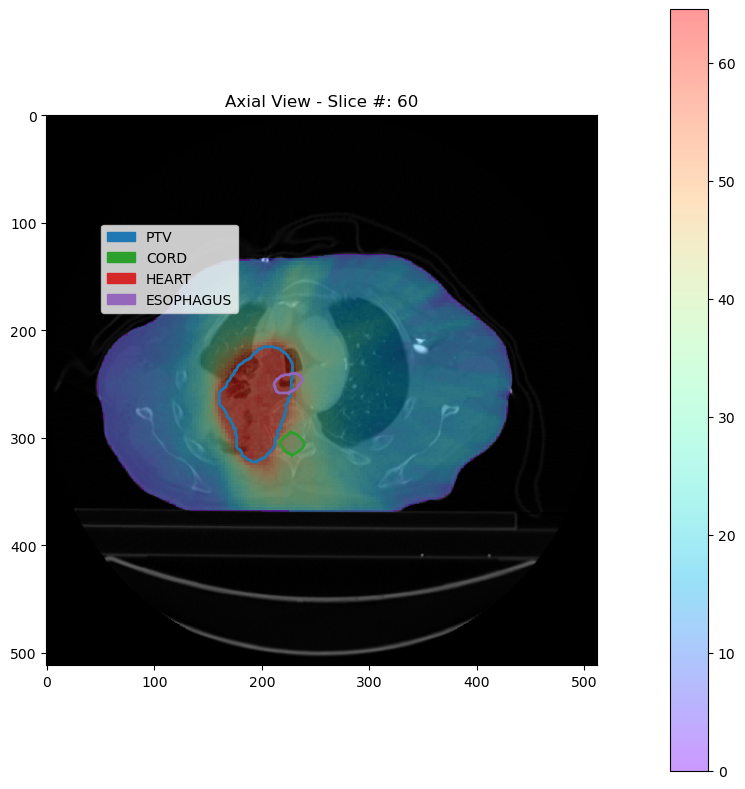

In [46]:
pp.Visualization.plot_2d_slice(my_plan=my_plan, dose_1d =solutions[-1]['act_dose_v'] * my_plan.get_num_of_fractions(), slice_num=60, struct_names=['PTV', 'CORD', 'HEART','ESOPHAGUS'], show_dose=True) 

### 6) Visualizing and Evaluating the plan in TPS (Utils class)
The following code generates an RT Plan DICOM file using the above solution, which can be imported into any TPS for final evaluation. 
We suggest you to go through notebook [vmat_tps_import.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/vmat_tps_import.ipynb) to learn about how to address the dependencies between optimization and final dose calculation before importing the plan into TPS.

In [17]:
# write plan to dicom file
# create dicom RT Plan file to be imported in TPS
out_rt_plan_file = r'C:\Temp\Lung_Patient_4\rt_plan_portpy_vmat.dcm'  # change this file directory based upon your needs
in_rt_plan_file = r'C:\Temp\Lung_Patient_4\rt_plan_echo_vmat.dcm'  # change this directory as per your
pp.write_rt_plan_vmat(my_plan=my_plan, in_rt_plan_file=in_rt_plan_file, out_rt_plan_file=out_rt_plan_file)
print('Done')